# Exploração do Ambiente

## Importações e Caminhos Base

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import heapq
import math

BASE_PATH = '../data/94x94_408v/'
RESULTS_PATH = '../results/exploration/'

env_config = open(os.path.join(BASE_PATH, 'env_config.txt')).readlines()
env_obst = os.path.join(BASE_PATH, 'env_obst.txt')
env_victims = pd.read_csv(os.path.join(BASE_PATH, 'env_victims.txt'), sep=',', header=None, names=['linha', 'coluna'])
WALL = 100.0

## Funções Utilitárias

In [35]:
def read_env_obstacles(path, grid_size):
    grid = np.ones(grid_size)
    with open(path) as f:
        for line in f:
            r, c, v = line.strip().split(',')
            grid[int(r), int(c)] = float(v)
    return grid

In [36]:
def in_sector(cell, base, agent_idx, n_agents=3, margin=10.0):
    dy = cell[1] - base[1]
    dx = cell[0] - base[0]
    ang = (math.degrees(math.atan2(dy, dx)) + 360) % 360
    sector_size = 360 / n_agents
    start = agent_idx * sector_size
    end = start + sector_size
    start_m = (start - margin) % 360
    end_m = (end + margin) % 360
    if start_m < end_m:
        return start_m <= ang <= end_m
    else:
        # sector crosses the 0-degree line
        return ang >= start_m or ang <= end_m

In [37]:
def a_star_known(grid, known_mask, start, goal):
    moves = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    open_set = [(0, start)]
    g_score = {start: 0}
    came_from = {}

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            # reconstrói caminho
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return g_score[goal], path

        x, y = current
        for dx, dy in moves:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]):
                continue
            if not known_mask[nx, ny] or grid[nx, ny] >= 100.0:
                continue

            move_cost = 1.5 * grid[nx, ny] if abs(dx)+abs(dy)==2 else 1.0 * grid[nx, ny]
            new_cost = g_score[current] + move_cost

            if (nx, ny) not in g_score or new_cost < g_score[(nx, ny)]:
                g_score[(nx, ny)] = new_cost
                came_from[(nx, ny)] = current
                h = (abs(nx - goal[0]) + abs(ny - goal[1])) * 1.2
                heapq.heappush(open_set, (new_cost + h, (nx, ny)))

    return None, None

## Definição de Parâmetros

In [38]:
AGENTS = [
{"name": f"EXPLORER_{i+1}", "color": (0, 0, 255), "trace_color": (153,153,255), "tlim": 1000, "cost_line": 1.0, "cost_diag": 1.5, "cost_read": 2.0, "cost_first_aid": 1.0}
for i in range(3)
]

conf = {}
for line in env_config:
    key, value = line.strip().split()
    conf[key] = value
line = env_config[0].strip()
coords = line.split(' ')[1]
x_str, y_str = coords.split(',')
BASE = (int(x_str), int(y_str))
grid_w, grid_h = int(conf["GRID_WIDTH"]), int(conf["GRID_HEIGHT"])
env_obst = read_env_obstacles(env_obst, (grid_h, grid_w))

print(f"Posição inicial: {BASE}, Tamanho do ambiente: {grid_w}x{grid_h}, Número de vítimas: {len(env_victims)}")

Posição inicial: (46, 46), Tamanho do ambiente: 94x94, Número de vítimas: 408


## Implementação do Online-DFS

In [39]:
def online_dfs(explorer, grid, victims_df, tlim, agent_idx):
    visited = set()
    path = [BASE]
    found_victims = []
    time_spent = 0
    path_costs = {BASE: 0}
    # known_map: boolean mask of discovered cells so a_star_known can index it
    known_map = np.zeros_like(grid, dtype=bool)
    tlimtarget = tlim / 2
    ret_cost = 0

    moves = [
        (-1, 0), (1, 0), (0, -1), (0, 1), # Movimentos horizontais e verticais
        (-1, -1), (-1, 1), (1, -1), (1, 1) # Movimentos diagonais
    ]

    visit_count = np.zeros_like(grid)

    # grid = read_env_obstacles(env_obst, (grid_w, grid_h))

    while path and time_spent < tlim:
        x, y = path[-1]
        visited.add((x, y))
        # mark discovered cell in the known map
        known_map[x, y] = True
        visit_count[x, y] += 1

        if any((x == r.linha and y == r.coluna) for r in victims_df.itertuples()):
            if (x, y) not in found_victims:
                found_victims.append((x, y))
                time_spent += explorer['cost_read']

        if tlimtarget <= time_spent + 5:
            ret_cost, ret_path = a_star_known(grid, known_map, (x, y), BASE)
            if ret_cost is not None and ret_cost < tlim - time_spent + 5:
                for step in ret_path:
                    sx, sy = step
                    if sx != path[-1][0] and sy != path[-1][1]:
                        path.append((sx, sy))
                        time_spent += explorer["cost_diag"] * grid[sx, sy]
                    else:
                        path.append((sx, sy))
                        time_spent += explorer["cost_line"] * grid[sx, sy]
                if path[-1] == BASE:
                    if time_spent <= tlim:
                        victims_found = pd.DataFrame(found_victims, columns=['linha', 'coluna'])
                        known_coords = np.argwhere(known_map)
                        known_map_pd = pd.DataFrame(known_coords, columns=['linha', 'coluna'])
                        return victims_found, path, time_spent, known_map_pd
                    else: 
                        return None, None, None, None
                else:
                    return None, None, None, None


        candidates = []
        for dx, dy in moves:
            nx, ny = x + dx, y + dy
            if not in_sector((nx, ny), BASE, agent_idx):
                continue
            if not (0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]):
                continue
            if grid[nx, ny] >= WALL:
                continue
            if (nx, ny) in visited:
                continue

            cost_move = explorer["cost_diag"] if abs(dx) + abs(dy) == 2 else explorer["cost_line"]
            cost_move *= grid[nx, ny]
            path_costs[(nx, ny)] = path_costs[(x, y)] + cost_move

            if time_spent + cost_move + ret_cost >= tlim:
                continue

            weight = 1.0 / (1 + visit_count[nx, ny])
            candidates.append((nx, ny, cost_move, weight))

        if candidates:
            weights = [c[-1] for c in candidates]
            chosen = random.choices(candidates, weights=weights, k=1)[0]
            nx, ny, move_cost, _ = chosen
            path.append((nx, ny))
            time_spent += move_cost
        else:
            path.pop()
            time_spent += explorer["cost_line"]

    victims_found = pd.DataFrame(found_victims, columns=['linha', 'coluna'])
    known_coords = np.argwhere(known_map)
    known_map_pd = pd.DataFrame(known_coords, columns=['linha', 'coluna'])
    return victims_found, path, time_spent, known_map_pd

## Execução da Simulação

In [40]:
results = {}

for tlim in [1000, 8000]:
    print(f"Executando simulação com tlim={tlim}")
    for i, agent in enumerate(AGENTS):
        victims_found, path, t_used, known_map = online_dfs(agent, env_obst, env_victims, tlim, i)
        victims_found.to_csv(f"{RESULTS_PATH}{agent['name'].lower()}_tlim{tlim}.csv", index=False)
        results[(agent["name"], tlim)] = len(victims_found)
        known_map.to_csv(f"{RESULTS_PATH}{agent['name'].lower()}_tlim{tlim}_knownmap.csv", index=False)
        print(f"{agent['name']} encontrou {len(victims_found):.0f} vítimas (tempo {(t_used)/1000:.4f}) finalizando em {path[-1] if path else 'N/A'}")


Executando simulação com tlim=1000
EXPLORER_1 encontrou 13 vítimas (tempo 0.5172) finalizando em (46, 46)
EXPLORER_2 encontrou 15 vítimas (tempo 0.5397) finalizando em (46, 46)
EXPLORER_3 encontrou 3 vítimas (tempo 0.5485) finalizando em (46, 46)
Executando simulação com tlim=8000
EXPLORER_1 encontrou 100 vítimas (tempo 4.0315) finalizando em (46, 46)
EXPLORER_2 encontrou 95 vítimas (tempo 4.0367) finalizando em (46, 46)
EXPLORER_3 encontrou 100 vítimas (tempo 4.0185) finalizando em (46, 46)


## Métricas e Sobreposição

In [41]:
def calc_sobreposicao(v1, v2, v3, v_total):
    return ((v1 + v2 + v3) / v_total) - 1

## Visualização (tlim1000)

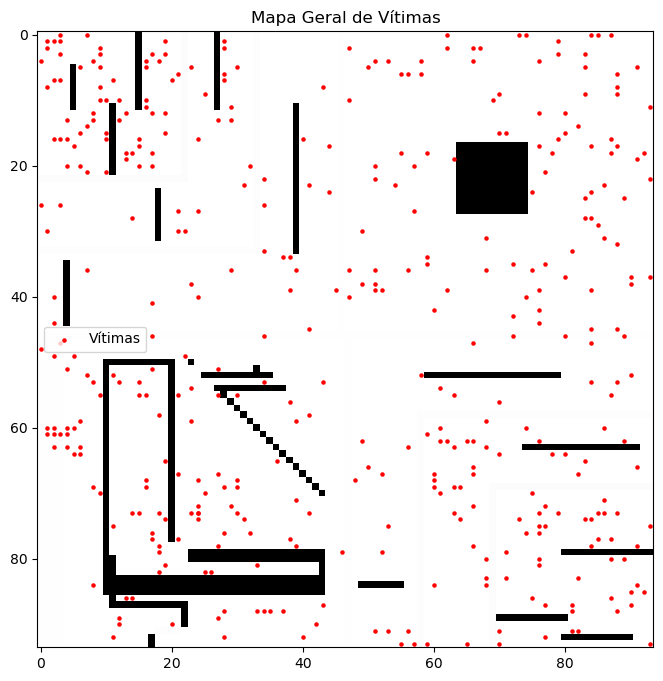

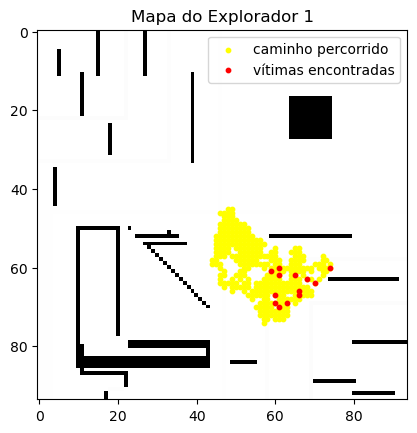

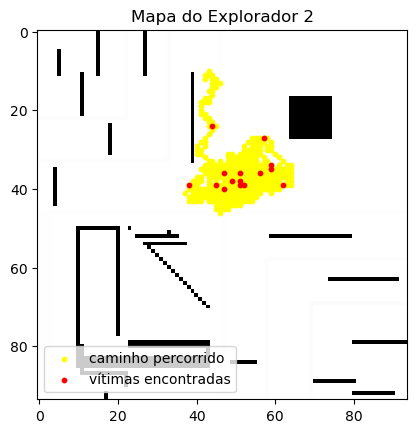

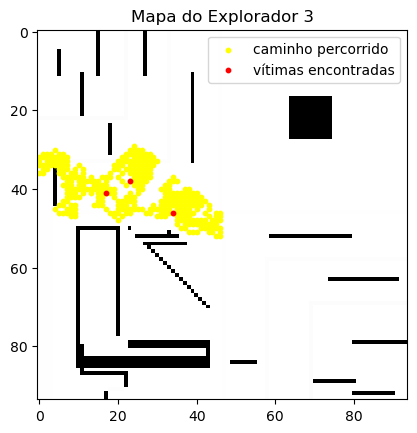

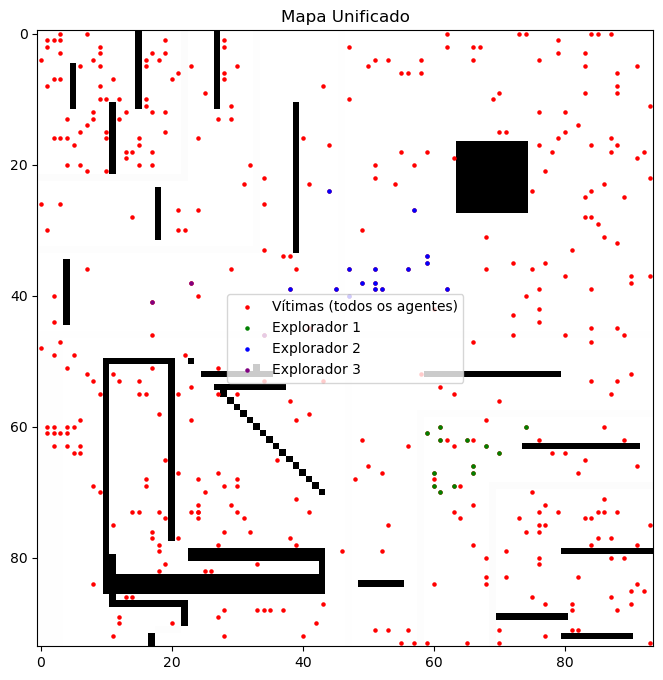

In [42]:
def plot_map(victims_df, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(env_obst, cmap='Greys', origin='upper')
    plt.scatter(victims_df['coluna'], victims_df['linha'], c='red', s=5, label='Vítimas')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_explorer_map(grid, victims_found, victims_knownmap, title):
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.scatter(victims_knownmap['coluna'], victims_knownmap['linha'], c='yellow', s=10, label='caminho percorrido')
    plt.scatter(victims_found['coluna'], victims_found['linha'], c='red', s=10, label='vítimas encontradas')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_unified_map(victims_df,victims1_df, victims2_df, victims3_df, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(env_obst, cmap='Greys', origin='upper')
    plt.scatter(victims_df['coluna'], victims_df['linha'], c='red', s=5, label='Vítimas (todos os agentes)')
    plt.scatter(victims1_df['coluna'], victims1_df['linha'], c='green', s=5, label='Explorador 1')
    plt.scatter(victims2_df['coluna'], victims2_df['linha'], c='blue', s=5, label='Explorador 2')
    plt.scatter(victims3_df['coluna'], victims3_df['linha'], c='purple', s=5, label='Explorador 3')
    plt.title(title)
    plt.legend()
    plt.show()

victims1_df = pd.read_csv(f"{RESULTS_PATH}explorer_1_tlim1000.csv")
victims2_df = pd.read_csv(f"{RESULTS_PATH}explorer_2_tlim1000.csv")
victims3_df = pd.read_csv(f"{RESULTS_PATH}explorer_3_tlim1000.csv")
victims1_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_1_tlim1000_knownmap.csv")
victims2_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_2_tlim1000_knownmap.csv")
victims3_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_3_tlim1000_knownmap.csv")

plot_map(env_victims, "Mapa Geral de Vítimas")
plot_explorer_map(env_obst, victims1_df, victims1_knownmap, "Mapa do Explorador 1")
plot_explorer_map(env_obst, victims2_df, victims2_knownmap, "Mapa do Explorador 2")
plot_explorer_map(env_obst, victims3_df, victims3_knownmap, "Mapa do Explorador 3")
plot_unified_map(env_victims, victims1_df, victims2_df, victims3_df, "Mapa Unificado")

## Visualização (tlim8000)

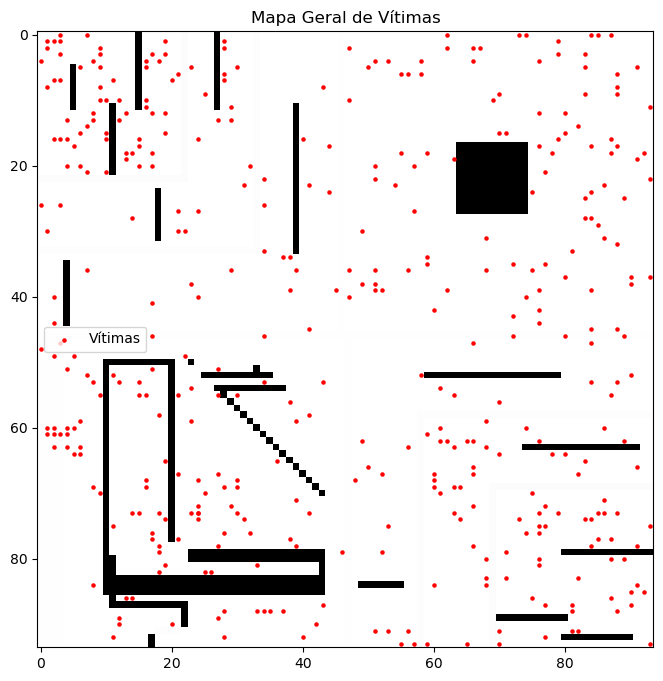

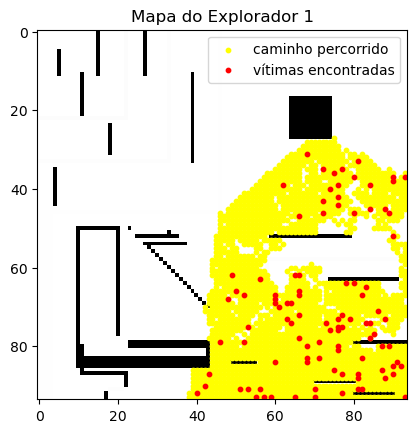

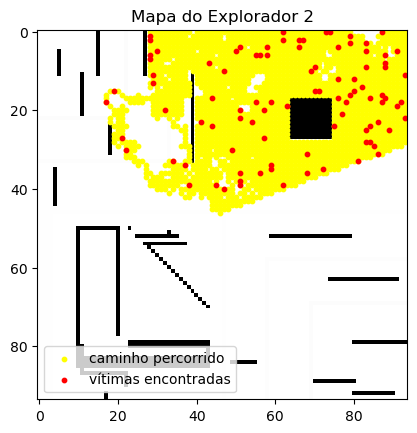

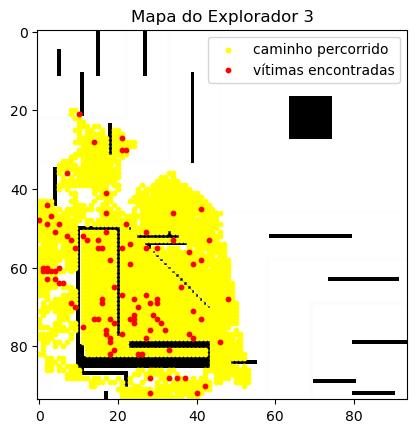

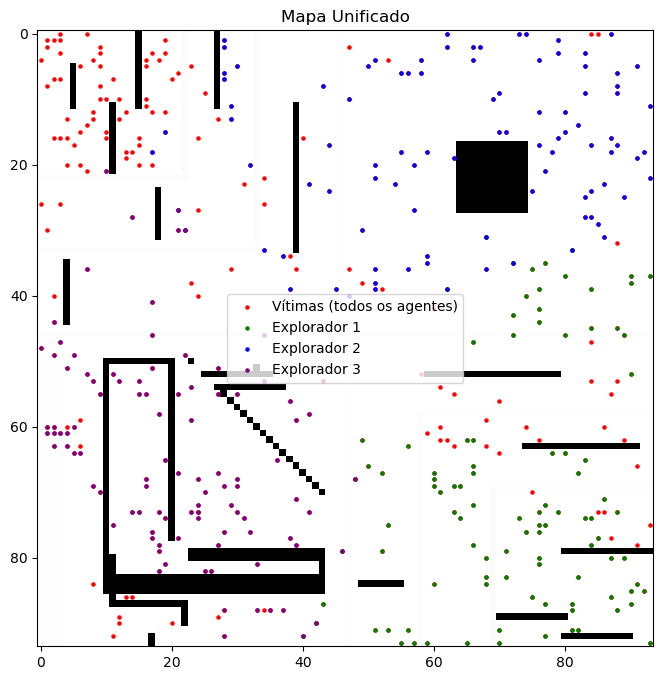

In [43]:
def plot_map(victims_df, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(env_obst, cmap='Greys', origin='upper')
    plt.scatter(victims_df['coluna'], victims_df['linha'], c='red', s=5, label='Vítimas')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_explorer_map(grid, victims_found, victims_knownmap, title):
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.scatter(victims_knownmap['coluna'], victims_knownmap['linha'], c='yellow', s=10, label='caminho percorrido')
    plt.scatter(victims_found['coluna'], victims_found['linha'], c='red', s=10, label='vítimas encontradas')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_unified_map(victims_df,victims1_df, victims2_df, victims3_df, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(env_obst, cmap='Greys', origin='upper')
    plt.scatter(victims_df['coluna'], victims_df['linha'], c='red', s=5, label='Vítimas (todos os agentes)')
    plt.scatter(victims1_df['coluna'], victims1_df['linha'], c='green', s=5, label='Explorador 1')
    plt.scatter(victims2_df['coluna'], victims2_df['linha'], c='blue', s=5, label='Explorador 2')
    plt.scatter(victims3_df['coluna'], victims3_df['linha'], c='purple', s=5, label='Explorador 3')
    plt.title(title)
    plt.legend()
    plt.show()

victims1_df = pd.read_csv(f"{RESULTS_PATH}explorer_1_tlim8000.csv")
victims2_df = pd.read_csv(f"{RESULTS_PATH}explorer_2_tlim8000.csv")
victims3_df = pd.read_csv(f"{RESULTS_PATH}explorer_3_tlim8000.csv")
victims1_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_1_tlim8000_knownmap.csv")
victims2_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_2_tlim8000_knownmap.csv")
victims3_knownmap = pd.read_csv(f"{RESULTS_PATH}explorer_3_tlim8000_knownmap.csv")

plot_map(env_victims, "Mapa Geral de Vítimas")
plot_explorer_map(env_obst, victims1_df, victims1_knownmap, "Mapa do Explorador 1")
plot_explorer_map(env_obst, victims2_df, victims2_knownmap, "Mapa do Explorador 2")
plot_explorer_map(env_obst, victims3_df, victims3_knownmap, "Mapa do Explorador 3")
plot_unified_map(env_victims, victims1_df, victims2_df, victims3_df, "Mapa Unificado")

## Junta em apenas um mapa

In [44]:
# concat knownmap files into one (ignore duplicates)
UNIFIED_RESULTS_PATH = '../results/unification/'
t1000knownfiles = [os.path.join(RESULTS_PATH, f) for f in os.listdir(RESULTS_PATH) if f.endswith('tlim1000_knownmap.csv')]
t8000knownfiles = [os.path.join(RESULTS_PATH, f) for f in os.listdir(RESULTS_PATH) if f.endswith('tlim8000_knownmap.csv')]
t1000victims = [os.path.join(RESULTS_PATH, f) for f in os.listdir(RESULTS_PATH) if f.endswith('tlim1000.csv')]
t8000victims = [os.path.join(RESULTS_PATH, f) for f in os.listdir(RESULTS_PATH) if f.endswith('tlim8000.csv')]

if not t1000knownfiles:
    print("No tlim1000_knownmap files found in", RESULTS_PATH)
else:
    dfs = [pd.read_csv(f) for f in t1000knownfiles]
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined.drop_duplicates().reset_index(drop=True)
    out_path = os.path.join(UNIFIED_RESULTS_PATH, "tlim1000_knownmap_all.csv")
    combined.to_csv(out_path, index=False)
    print(f"Combined {len(t1000knownfiles)} files -> {out_path} ({len(combined)} unique rows)")

if not t8000knownfiles:
    print("No tlim8000_knownmap files found in", RESULTS_PATH)
else:
    dfs = [pd.read_csv(f) for f in t8000knownfiles]
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined.drop_duplicates().reset_index(drop=True)
    out_path = os.path.join(UNIFIED_RESULTS_PATH, "tlim8000_knownmap_all.csv")
    combined.to_csv(out_path, index=False)
    print(f"Combined {len(t8000knownfiles)} files -> {out_path} ({len(combined)} unique rows)")

if not t1000victims:
    print("No tlim1000 files found in", RESULTS_PATH)
else:
    dfs = [pd.read_csv(f) for f in t1000victims]
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined.drop_duplicates().reset_index(drop=True)
    out_path = os.path.join(UNIFIED_RESULTS_PATH, "tlim1000_victims_all.csv")
    combined.to_csv(out_path, index=False)
    print(f"Combined {len(t1000victims)} files -> {out_path} ({len(combined)} unique rows)")

if not t8000victims:
    print("No tlim8000 files found in", RESULTS_PATH)
else:
    dfs = [pd.read_csv(f) for f in t8000victims]
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined.drop_duplicates().reset_index(drop=True)
    out_path = os.path.join(UNIFIED_RESULTS_PATH, "tlim8000_victims_all.csv")
    combined.to_csv(out_path, index=False)
    print(f"Combined {len(t8000victims)} files -> {out_path} ({len(combined)} unique rows)")


Combined 3 files -> ../results/unification/tlim1000_knownmap_all.csv (1005 unique rows)
Combined 3 files -> ../results/unification/tlim8000_knownmap_all.csv (6158 unique rows)
Combined 3 files -> ../results/unification/tlim1000_victims_all.csv (31 unique rows)
Combined 3 files -> ../results/unification/tlim8000_victims_all.csv (285 unique rows)
